In [2]:
from PIL import Image
import glob
import numpy as np

def load_images_from_folder(folder, size=(64, 64)):
    images = []
    for filename in glob.glob(f'{folder}/*.jpg'): # Adjust the path if needed
        with Image.open(filename) as img:
            img = img.resize(size)
            images.append(np.array(img))
    return np.array(images)


In [6]:
from tqdm import tqdm
import os 
import numpy as np

def load_dataset(base_path, n_objects=51, n_images_per_object=10):
    all_images = []
    for i in tqdm(range(n_objects), desc="Loading Images"):
        folder_name = os.path.join(base_path, f'{i:05d}_*')  # Adjust the format as per your folder naming
        for folder in glob.glob(folder_name):
            images = load_images_from_folder(folder)
            all_images.extend(images)
    return np.array(all_images)

# Load dataset
dataset_path = "C:/Users/omara/Downloads/Things_training_images-20231205T194843Z-001/Things_training_images"
dataset = load_dataset(dataset_path)

# Normalize the dataset
images50 = dataset / 255.0  # Normalize pixel values to [0, 1]

Loading Images: 100%|██████████| 51/51 [00:06<00:00,  8.01it/s]


In [8]:
#loading in eeg data
eeg_parent_dir = "C:/Users/omara/Downloads/sub01"
eeg_data_train = np.load(os.path.join(eeg_parent_dir,
    'preprocessed_eeg_training.npy'), allow_pickle=True).item()

print('Training EEG data shape:')
print(eeg_data_train['preprocessed_eeg_data'].shape)
print('(Training image conditions × Training EEG repetitions × EEG channels × '
    'EEG time points)')

# Assuming each image class has 10 images and you want the first 50 classes
n_classes = 50
n_images_per_class = 10
total_images_needed = n_classes * n_images_per_class

# Slicing the EEG data to include only the first 500 (50 classes * 10 images each)
eeg_data_train_subset = eeg_data_train['preprocessed_eeg_data'][:total_images_needed]

# Verify the new shape of the EEG data
print("New shape of training EEG data:")
print(eeg_data_train_subset.shape)  # Should output (500, 4, 17, 100)

Training EEG data shape:
(16540, 4, 17, 100)
(Training image conditions × Training EEG repetitions × EEG channels × EEG time points)
New shape of training EEG data:
(500, 4, 17, 100)


In [1]:
##SUPPORTING 10 PATIENTS
import pickle

# The path where the pickled data is stored
pickle_file_path = "C:/Users/omara/OneDrive/Desktop/cs236proje/images_dataset.pkl"

# Function to load the numpy array of images from a pickle file
def load_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Load the images numpy array
images = load_from_pickle(pickle_file_path)

# Check the shape of the loaded data if needed
print(images.shape)
print(type(images))

(16540, 64, 64, 3)
<class 'numpy.ndarray'>


In [2]:
##SUPPORTING 10 PATIENTS
import pickle

# The path where the pickled data is stored
pickle_file_path = "C:/Users/omara/OneDrive/Desktop/cs236proje/eeg_dataset.pkl"

# Function to load the numpy array of images from a pickle file
def load_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Load the images numpy array
alleegdata = load_from_pickle(pickle_file_path)

# Check the shape of the loaded data if needed
print(alleegdata.shape)
print(type(alleegdata))

(16540, 10, 4, 17, 100)
<class 'numpy.ndarray'>


In [118]:
# first 100 image classes
images50 = images[:500]
eeg50 = alleegdata[:500]

In [119]:
print(images50.shape)
print(eeg50.shape)

(500, 64, 64, 3)
(500, 10, 4, 17, 100)


In [69]:
import torch
# use real fft from torch, and only want the real magnitudes for each frequency, and do it on the last dimension, so time points. eeg100 has shape (100, 10, 4, 17, 100)
eeg100_tensor = torch.tensor(eeg100).float()

# Apply real FFT on the last dimension (time points)
fft_output = torch.fft.rfft(eeg100_tensor, dim=-1)

# Compute the magnitudes (absolute values) of the FFT output
fft_magnitudes = torch.abs(fft_output)

# Reshape the output if necessary for further processing
# The shape will now be [100, 10, 4, 17, 51] because the last dimension is halved + 1
# (real FFT output size for input size N is N/2+1)
fft_magnitudes_reshaped = fft_magnitudes.reshape(1000, 10, 4, 17, -1)

In [70]:
fft_magnitudes_reshaped.shape

torch.Size([1000, 10, 4, 17, 51])

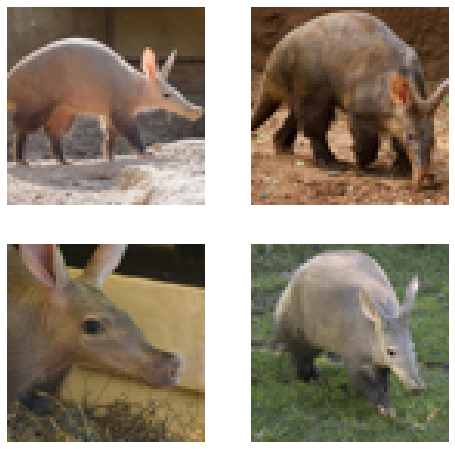

In [14]:
import matplotlib.pyplot as plt

# Creating a 2x2 grid of images from the simulated dataset

# Create a figure for the 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Iterate over the grid and display images
for i in range(4):
    axs[i // 2, i % 2].imshow(images[i], interpolation='nearest')
    axs[i // 2, i % 2].axis('off')  # Turn off axis
plt.savefig("aardvarks.pdf", bbox_inches='tight')
plt.show()


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [326]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim, num_patients):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_patients = num_patients

        # EEG encoder
        # Incorporate patient dimension in the input layer
        self.eeg_encoder = nn.Sequential(
            nn.Flatten(start_dim=1),  # Flatten starting from the patient dimension
            nn.Linear(eeg_size * num_patients, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Image encoder
        self.image_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eeg, image):
        eeg_latent = self.eeg_encoder(eeg)
        image_latent = self.image_encoder(image)

        # Split the result into mean and log-variance
        eeg_mu, eeg_log_var = torch.chunk(eeg_latent, 2, dim=1)
        image_mu, image_log_var = torch.chunk(image_latent, 2, dim=1)

        # Combine EEG and image information in latent space
        mu = (eeg_mu + image_mu) / 2
        log_var = (eeg_log_var + image_log_var) / 2

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)
        return recon_image, mu, log_var, eeg_mu, eeg_log_var

# Initialize the model
eeg_size = 4 * 17 * 100  # Size per patient
num_patients = 10  # Number of patients
image_size = 64 * 64 * 3
latent_dim = 25
cvae = CVAE(eeg_size, image_size, latent_dim, num_patients)

In [327]:
def cvae_loss(recon_image, original_image, mu, log_var):
    # Reconstruction loss (MSE for simplicity)
    recon_loss = F.mse_loss(recon_image, original_image, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + 0.2 * kl_loss

In [328]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Convert the datasets to PyTorch tensors
# images50_tensor = torch.tensor(images50).float()  # Convert images to float tensors
# eeg_data_tensor = torch.tensor(eeg_data_train_subset).float()  # Convert EEG data to float tensors

# images50_tensor = images50_tensor.reshape(-1, 64*64*3)
# eeg_data_tensor = eeg_data_tensor.reshape(-1, 4*17*100)

# print("EEG data tensor shape:", eeg_data_tensor.shape)
# print("Image tensor shape:", images50_tensor.shape)
# # Create a dataset from the tensors
# dataset = TensorDataset(eeg_data_tensor, images50_tensor)

# # Create a DataLoader
# batch_size = 32  # You can adjust the batch size

# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#################################################################################################################################################################################################
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert the datasets to PyTorch tensors
images_tensor = torch.tensor(images50).float()  # Convert images to float tensors
eeg_data_tensor = torch.tensor(eeg50).float()  # Convert EEG data to float tensors
#fft_magnitudes_reshaped

# Reshape the image tensor to be compatible with the CVAE model
images_tensor = images_tensor.reshape(-1, 64*64*3)

#REGULAR CVAE (NO LSTM)
eeg_data_tensor = eeg_data_tensor.reshape(-1, 10 * 4 * 17 * 100)

#WITH LSTM LAYER
#eeg_data_tensor = eeg_data_tensor.reshape(-1, 100, 10 * 4 * 17)  # Assuming 100 is the sequence length

#WITH TRANSFORMER
# New shape will be (sequence length, batch size, features per time step)
# eeg_data_tensor = eeg_data_tensor.permute(4, 0, 1, 2, 3)  # Reorder to bring the sequence length to the front
# eeg_data_tensor = eeg_data_tensor.reshape(100, -1, 10 * 4 * 17)  # Assuming 100 is the sequence length#


print("EEG data tensor shape:", eeg_data_tensor.shape)
print("Image tensor shape:", images_tensor.shape)

# Create a dataset from the tensors
dataset = TensorDataset(eeg_data_tensor, images_tensor)

# Create a DataLoader
batch_size = 128  # You can adjust the batch size

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


EEG data tensor shape: torch.Size([500, 68000])
Image tensor shape: torch.Size([500, 12288])


In [329]:
import torch.optim as optim

# Assuming cvae is your model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the chosen device
cvae = cvae.to(device)

# Define an optimizer
optimizer = optim.Adam(cvae.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    for eeg, image in data_loader:
        # Move data to the same device as the model
        eeg = eeg.to(device)
        image = image.to(device)

        # Forward pass
        recon_image, mu, log_var, _, _ = cvae(eeg, image)

        # Compute loss
        loss = cvae_loss(recon_image, image, mu, log_var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 109750.3359
Epoch [2/100], Loss: 96427.3984
Epoch [3/100], Loss: 98037.7188
Epoch [4/100], Loss: 87834.7578
Epoch [5/100], Loss: 83743.6328
Epoch [6/100], Loss: 85535.1641
Epoch [7/100], Loss: 76876.3438
Epoch [8/100], Loss: 75638.5547
Epoch [9/100], Loss: 72968.3984
Epoch [10/100], Loss: 68453.0547
Epoch [11/100], Loss: 69164.5938
Epoch [12/100], Loss: 70252.2031
Epoch [13/100], Loss: 62069.2383
Epoch [14/100], Loss: 65916.3984
Epoch [15/100], Loss: 58992.2383
Epoch [16/100], Loss: 55094.5312
Epoch [17/100], Loss: 56349.7422
Epoch [18/100], Loss: 56695.5273
Epoch [19/100], Loss: 56790.9102
Epoch [20/100], Loss: 53035.6250
Epoch [21/100], Loss: 52686.6367
Epoch [22/100], Loss: 53383.9844
Epoch [23/100], Loss: 51007.7656
Epoch [24/100], Loss: 48649.6875
Epoch [25/100], Loss: 48891.2070
Epoch [26/100], Loss: 48585.1406
Epoch [27/100], Loss: 48909.6250
Epoch [28/100], Loss: 47312.4727
Epoch [29/100], Loss: 46931.3828
Epoch [30/100], Loss: 43592.3516
Epoch [31/100], Lo

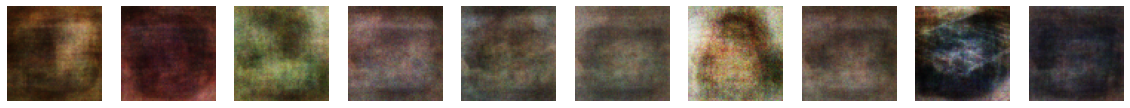

In [330]:
import matplotlib.pyplot as plt

# Select the first 10 EEG scans
eeg_samples = eeg_data_tensor[10:20].to(device)

# Create a dummy image input with the correct size
# The dummy image batch should have the same batch size as the EEG samples and the correct image size
dummy_image_input = torch.zeros((eeg_samples.shape[0], 12288)).to(device)

# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _, _, _ = cvae(eeg_samples, dummy_image_input)


# Convert the reconstructed images to NumPy for visualization
reconstructed_images = reconstructed_images.cpu().numpy()

# Reshape and scale the images as needed for visualization
reconstructed_images = reconstructed_images.reshape(-1, 64, 64, 3)  # Adjust the shape as per your original images

# Plotting
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])
    ax.axis('off')
plt.show()

In [24]:
unseen_eeg_scans = eeg_data_train['preprocessed_eeg_data'][500:600]
unseen_eeg_scans_tensor = torch.tensor(unseen_eeg_scans).float().to(device)

unseen_eeg_scans_tensor = unseen_eeg_scans_tensor.permute(1, 0, 2, 3)
unseen_eeg_scans_tensor = unseen_eeg_scans_tensor.reshape(-1, 17, 100)

In [331]:
import numpy as np
def extract_latents(model, eeg_data, device):
    model.eval()  # Set the model to evaluation mode
    latents = []

    with torch.no_grad():
        for eeg in DataLoader(eeg_data, batch_size=32):
            eeg = eeg.to(device)
            # Create a dummy image input with the correct size
            dummy_image_input = torch.zeros((eeg.shape[0], 12288)).to(device)

            # Get the latent representations. Assuming they are the second output of the model
            _, latents_batch, _, _, _ = model(eeg, dummy_image_input)
            latents.append(latents_batch.cpu().numpy())

    return np.concatenate(latents, axis=0)

# Extract latent vectors for the EEG data
latent_vectors = extract_latents(cvae, eeg_data_tensor, device)


In [332]:
latent_vectors

array([[ 1.4389205 , -2.7022405 ,  2.7060072 , ...,  0.6572689 ,
         0.12191708, -2.7425473 ],
       [ 1.5575929 , -2.2994616 ,  2.2351706 , ...,  1.9861107 ,
         1.2177325 , -4.01764   ],
       [ 2.1594183 , -2.6453896 ,  3.141429  , ...,  0.6105958 ,
         0.1644057 , -2.456093  ],
       ...,
       [ 1.5642984 , -2.7540774 ,  2.2574923 , ...,  2.6572654 ,
        -0.869272  , -2.3716865 ],
       [ 1.475309  , -1.146006  ,  1.7559661 , ...,  0.14786482,
         1.4585141 , -3.6404655 ],
       [ 2.1115642 , -1.8980154 ,  3.213049  , ...,  1.3249776 ,
         1.0165054 , -3.1342463 ]], dtype=float32)

In [157]:
latent_vectors.shape
#NUMBER OF EEG RECORDINGS, LATENT DIMENSION

(500, 10)

In [333]:
n_classes = 50
n_images_per_class = 10
total_images = n_classes * n_images_per_class  # 500 in your case

eeg_labels = []
for class_label in range(n_classes):
    eeg_labels.extend([class_label] * n_images_per_class)

# Now eeg_labels is a list of 500 elements, where each element is the class label
# Convert it to a numpy array if needed
eeg_labels = np.array(eeg_labels)

# Verify the labels
print(eeg_labels)
print("Length of EEG labels:", len(eeg_labels))


[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

In [159]:
len(eeg_labels)

500

In [334]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Extract latent vectors for EEG data (you already have this step)
latent_vectors = extract_latents(cvae, eeg_data_tensor, device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    latent_vectors, eeg_labels, test_size=0.2, random_state=42
)

# Train an SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:g}%")


Accuracy: 5%


In [335]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf * 100:g}%")

Random Forest Accuracy: 16%


In [336]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.10g}%")


Accuracy: 5%


In [337]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can experiment with the number of neighbors
knn_classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred_knn = knn_classifier.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")


KNN Accuracy: 9.00%


In [338]:
y_pred_knn

array([ 6, 11,  0,  1, 48, 36,  8, 22,  4,  8,  0, 31, 13,  3, 14, 13, 33,
        0,  6,  9, 13, 19,  1, 11, 14, 46,  0,  1,  4, 43, 47, 29,  4, 30,
        0,  0,  3, 14,  1,  6,  5, 42, 22,  4, 10,  5,  5, 48, 22,  3,  0,
       42,  6,  5, 11,  1,  0, 11,  3,  9, 25,  5, 29, 48,  7, 11,  3,  0,
        4,  4,  2, 20, 22, 29, 16, 27,  5, 11,  0, 13,  4,  0,  0, 12,  0,
       23, 11, 16, 22, 26, 38, 31,  0, 14, 15,  4, 24,  5, 14,  4])

In [339]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size // 4, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Assuming your latent vector size and number of classes
input_size = latent_vectors.shape[1]
hidden_size = 256  # You can experiment with this
num_classes = 100  # As you have 50 image classes
model = SimpleNN(input_size, hidden_size, num_classes)


In [340]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(latent_vectors).float()
y_tensor = torch.tensor(eeg_labels).long()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create dataloaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # You can experiment with the number of epochs
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}')


Epoch [1/1000], Loss: 4.5535
Epoch [2/1000], Loss: 4.2917
Epoch [3/1000], Loss: 4.1462
Epoch [4/1000], Loss: 4.0651
Epoch [5/1000], Loss: 3.8849
Epoch [6/1000], Loss: 3.8080
Epoch [7/1000], Loss: 3.7957
Epoch [8/1000], Loss: 3.9137
Epoch [9/1000], Loss: 3.7220
Epoch [10/1000], Loss: 3.5836


In [341]:
# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test data: {accuracy:.2f}%')


Accuracy of the network on the test data: 7.00%


In [342]:
from sklearn.metrics import roc_auc_score

model.eval()  # Set the model to evaluation mode
all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_outputs.append(outputs)
        all_labels.append(labels)

# Concatenate all outputs and labels
all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()


In [343]:
# Compute the AUROC for each class
auroc_per_class = []
valid_classes = 0  # Counter for classes with at least one positive example

for i in range(num_classes):
    if (all_labels == i).any():  # Check if there is at least one positive example
        # Compute AUROC for this class
        auroc = roc_auc_score((all_labels == i), F.softmax(all_outputs, dim=1)[:, i])
        auroc_per_class.append(auroc)
        valid_classes += 1

# Calculate the average AUROC only for valid classes
if valid_classes > 0:
    average_auroc = sum(auroc_per_class) / valid_classes
    print(f'Average AUROC across {valid_classes} valid classes: {average_auroc:.4f}')
else:
    print("No valid classes found for AUROC computation")


Average AUROC across 44 valid classes: 0.6704


ValueError: All arrays must be of the same length

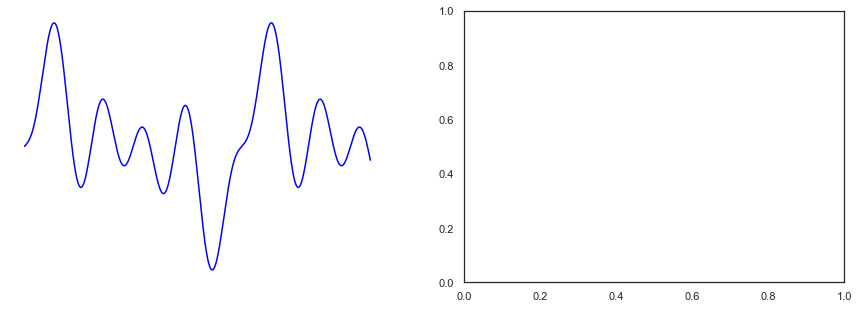

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generating the time series data with sin(x) + sin(2x) + sin(3x) - sin(5x)
x = np.linspace(0, 10, 1000)
time_series = np.sin(x) + np.sin(2*x) + np.sin(3*x) - np.sin(5*x)

# Applying real FFT to the new time series data
real_fft_data = np.fft.rfft(time_series)
frequency = np.fft.rfftfreq(len(time_series))

# Adjusting the x-axis scale for the FFT graph to focus on the peaks
x_fft_zoomed = frequency[:20]

# Creating subplots with white background and no spines
sns.set(style="white")
fig, axes = plt.subplots(1, 2, figsize=(15, 5), frameon=False)

# Plotting the sin time series data
sns.lineplot(ax=axes[0], x=x, y=time_series, color="blue")
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(labelleft=False, labelbottom=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

# Plotting the real FFT of the sin time series data with a more focused x-axis
sns.lineplot(ax=axes[1], x=x_fft_zoomed, y=np.abs(real_fft_data)[:30], color="red")
axes[1].set_title('')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(labelleft=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# Adjusting layout
plt.tight_layout()
plt.savefig("time_series_and_fft.pdf", format='pdf')
plt.show()


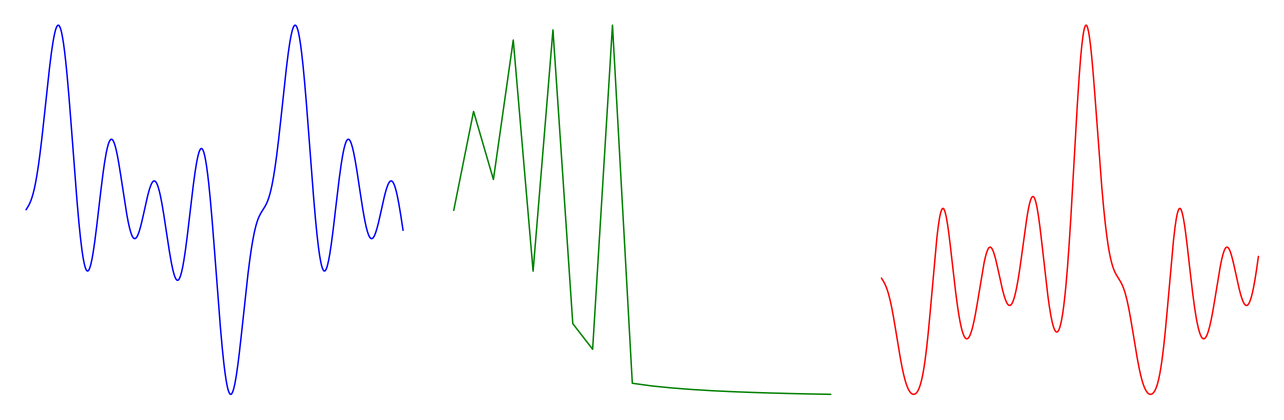

In [370]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from scipy.fft import rfft, rfftfreq

# Generate the time series data
x = np.linspace(0, 10, 1000)
time_series = np.sin(x) + np.sin(2*x) + np.sin(3*x) - np.sin(5*x)
time_series = time_series.reshape((1000, 1))

# Normalize the data for LSTM
time_series_normalized = (time_series - np.mean(time_series)) / np.std(time_series)

# Convert to PyTorch tensor
time_series_tensor = torch.Tensor(time_series_normalized).unsqueeze(-1)

# Define a simple LSTM model in PyTorch
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = SimpleLSTM()

# Pass the data through the LSTM model (inference mode)
with torch.no_grad():
    lstm_output = model(time_series_tensor)

# Convert LSTM output back to numpy array and rescale to original scale
lstm_output_numpy = lstm_output.numpy().reshape(-1)
lstm_output_rescaled = lstm_output_numpy * np.std(time_series) + np.mean(time_series)

# FFT
fft_output = rfft(time_series.squeeze())
fft_freq = rfftfreq(len(time_series.squeeze()))

# Plotting
sns.set(style="white")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), frameon=False)

# Original Time Series
sns.lineplot(ax=axes[0], x=x, y=time_series[:, 0], color="blue")
axes[0].set_title('')
axes[0].tick_params(labelleft=False, labelbottom=False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

# FFT Output
# Plotting the real FFT of the sin time series data with a more focused x-axis
sns.lineplot(ax=axes[1], x=x_fft_zoomed, y=np.abs(real_fft_data)[:20], color="green")
axes[1].set_title('')
axes[1].tick_params(labelleft=False, labelbottom=False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# LSTM Output
sns.lineplot(ax=axes[2], x=x, y=lstm_output_rescaled, color="red")
axes[2].set_title('')
axes[2].tick_params(labelleft=False, labelbottom=False)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].spines['bottom'].set_visible(False)
axes[2].spines['left'].set_visible(False)

# Adjusting layout
plt.tight_layout()

# Save the figure as a PDF file
plt.savefig("time_series_fft_lstm_output.pdf", format='pdf')

# Display the figure
plt.show()
